In [159]:
import random as rd
import itertools
import warnings
import scipy
import plotly.graph_objects as go
import plotly.express as px 
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from sklearn import preprocessing
import numpy as np
from torch.autograd import Variable
from sklearn.cross_decomposition import PLSRegression


In [160]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y):
        self.X = X
        self.y = y
#         self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() 

    def __getitem__(self, index):
        return ((self.X[index,:]), (self.y[index]))
    
class Autoencoder_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(200, 32), # (N, 784) -> (N, 128)
            nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
            nn.Linear(32, 16) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 32),
            nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
            nn.Linear(32, 200)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    
class Autoencoder_Linear_watch(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(200, 64), # (N, 784) -> (N, 128)
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
#             nn.Linear(32, 32),
#             nn.ReLU(),
            nn.Linear(64, 16) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
#             nn.Linear(64, 64),
#             nn.ReLU(),
            nn.Linear(64, 200)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


## Очистка данных

In [161]:
df = np.load('series.npy', allow_pickle=True)
df = pd.DataFrame(df, columns = [str(i) for i in np.arange(2950)]+ ['UserID', 'Activity', 'Device'])
df.drop(df[(df.Device==0) & (df.UserID==1600) & (df.Activity=='A')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1607) & (df.Activity=='J')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1609) & (df.Activity=='B')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1616) & (df.Activity=='F')].index[0], inplace = True)
df.drop(df[(df.Device==0) & (df.UserID==1637) & (df.Activity=='J')].index[0], inplace = True)
df.drop(df[(df.Device==0) & (df.UserID==1639) & (df.Activity=='L')].index[0], inplace = True)
df.drop(df[(df.Device==1) & (df.UserID==1643) & (df.Activity=='I')].index[0], inplace = True)

In [162]:

df_smartphone = df.loc[(df['Device']==0)]   
df_smartwatch = df.loc[(df['Device']==1)] 

mean_smartphone = np.array(df_smartphone[df_smartphone.columns[:-3]] - np.mean(df_smartphone[df_smartphone.columns[:-3]]))


dataset = TimeseriesDataset(torch.from_numpy(np.array(mean_smartphone, dtype = np.float32)[:,:200]), torch.from_numpy(np.array(df_smartphone.Device, dtype = np.int32)))
data_loader = torch.utils.data.DataLoader(dataset,
                                             batch_size=256, shuffle=False)

   
mean_watch= np.array(df_smartwatch[df_smartwatch.columns[:-3]] - np.mean(df_smartwatch[df_smartwatch.columns[:-3]]))


dataset_watch = TimeseriesDataset(torch.from_numpy(np.array(mean_watch, dtype = np.float32)[:,:200]), torch.from_numpy(np.array(df_smartwatch.Device, dtype = np.int32)))
data_loader_watch = torch.utils.data.DataLoader(dataset_watch,
                                             batch_size=256, shuffle=False)


In [163]:
df_smartphone

,0,1,2,3,4,5,6,7,8,9,...,2943,2944,2945,2946,2947,2948,2949,UserID,Activity,Device
1,5.669901,8.334176,13.991527,18.773289,15.229046,8.590512,9.37682,8.505216,6.36051,5.277337,...,5.133331,5.524804,7.0107,11.583698,15.683448,19.18094,6.724602,1600,A,0
3,4.963312,4.1207,4.461069,10.417529,24.557747,14.150283,11.749508,2.56808,6.010665,5.943386,...,16.874018,13.414932,15.876094,15.486905,6.033484,4.782032,2.193758,1600,B,0
5,8.922215,10.107369,12.619653,14.1654,14.4989,12.724345,9.977381,10.104491,8.69097,7.104563,...,12.896634,14.29725,16.814279,10.886078,9.993947,9.681802,9.504079,1600,C,0
7,9.158156,9.159215,9.237526,9.229191,9.221939,9.23488,9.132225,9.230728,9.188579,9.170169,...,9.192168,9.147089,9.204193,9.161737,9.203675,9.212461,9.17517,1600,D,0
9,9.833691,9.847231,9.864307,9.824688,9.794464,9.822862,9.811741,9.800728,9.786877,9.80765,...,9.791054,9.782518,9.759729,9.764164,9.785598,9.775785,9.771731,1600,E,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1813,9.790932,10.138961,10.040632,9.693121,9.731227,9.599283,9.235905,8.946412,9.247427,9.745499,...,9.029446,9.111423,9.372934,9.547696,9.427512,9.343374,9.497171,1650,O,0
1815,10.341598,9.841165,9.393735,8.768042,8.518949,8.990967,9.152816,9.097333,9.162296,9.04878,...,9.375733,9.352531,9.370535,9.450588,9.513772,9.502059,9.541454,1650,P,0
1817,15.419159,17.362782,21.580194,25.264857,28.37524,32.829742,35.766782,33.576594,30.05997,26.19362,...,9.535223,9.52307,9.526023,9.534359,9.538128,9.519361,9.512945,1650,Q,0
1819,12.656527,12.212649,11.58976,10.285465,9.524546,11.895721,13.210253,14.484458,15.043702,13.648362,...,9.978013,9.744049,9.420098,9.470549,9.504792,9.684439,9.789111,1650,R,0


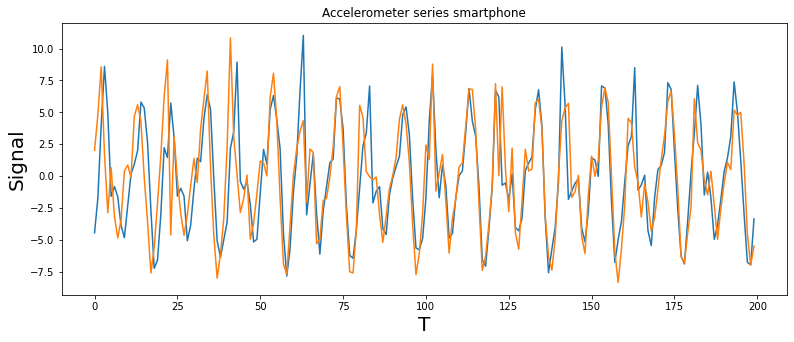

In [208]:
plt.figure(figsize=(13,5))
plt.xlabel("T", fontsize = 20)
plt.ylabel("Signal", fontsize = 20)
plt.title('Accelerometer series smartphone')
plt.plot(mean_smartphone[0,:200])
plt.plot(mean_smartphone[0,200:400])

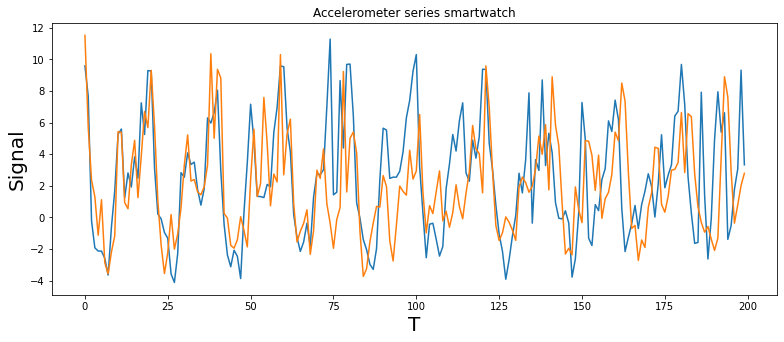

In [207]:
plt.figure(figsize=(13,5))
plt.xlabel("T", fontsize = 20)
plt.ylabel("Signal", fontsize = 20)
plt.title('Accelerometer series smartwatch')
plt.plot(mean_watch[0,:200])
plt.plot(mean_watch[0,200:400])

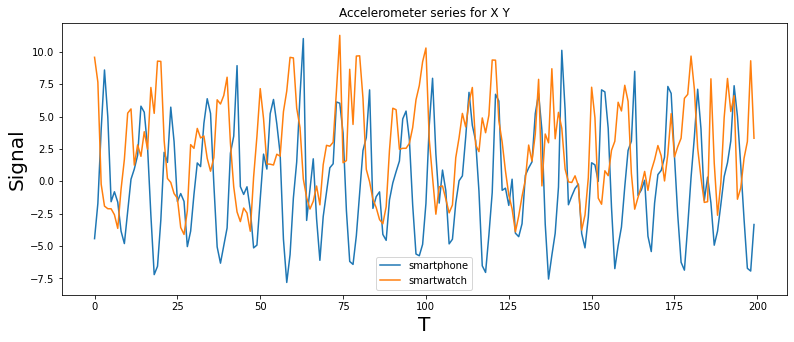

In [190]:

plt.figure(figsize=(13,5))
plt.xlabel("T", fontsize = 20)
plt.ylabel("Signal", fontsize = 20)
plt.title('Accelerometer series for X Y')
plt.plot(mean_smartphone[0,:200], label = 'smartphone')
plt.plot(mean_watch[0,:200], label = 'smartwatch')
plt.legend()
# plt.plot(mean_smartphone[0,200:400])

In [167]:

model = Autoencoder_Linear().cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=7e-4)

num_epochs = 100
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader:
        img = img.cuda()
        recon = model(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:10.0421
Epoch:2, Loss:9.9976
Epoch:3, Loss:9.9611
Epoch:4, Loss:9.9225
Epoch:5, Loss:9.8705
Epoch:6, Loss:9.8019
Epoch:7, Loss:9.7113
Epoch:8, Loss:9.5980
Epoch:9, Loss:9.4673
Epoch:10, Loss:9.3247
Epoch:11, Loss:9.1767
Epoch:12, Loss:9.0281
Epoch:13, Loss:8.8767
Epoch:14, Loss:8.7284
Epoch:15, Loss:8.5833
Epoch:16, Loss:8.4397
Epoch:17, Loss:8.3014
Epoch:18, Loss:8.1688
Epoch:19, Loss:8.0401
Epoch:20, Loss:7.9141
Epoch:21, Loss:7.7918
Epoch:22, Loss:7.6719
Epoch:23, Loss:7.5536
Epoch:24, Loss:7.4351
Epoch:25, Loss:7.3188
Epoch:26, Loss:7.2040
Epoch:27, Loss:7.0905
Epoch:28, Loss:6.9781
Epoch:29, Loss:6.8674
Epoch:30, Loss:6.7580
Epoch:31, Loss:6.6501
Epoch:32, Loss:6.5438
Epoch:33, Loss:6.4382
Epoch:34, Loss:6.3344
Epoch:35, Loss:6.2336
Epoch:36, Loss:6.1351
Epoch:37, Loss:6.0340
Epoch:38, Loss:5.9382
Epoch:39, Loss:5.8472
Epoch:40, Loss:5.7593
Epoch:41, Loss:5.6751
Epoch:42, Loss:5.5944
Epoch:43, Loss:5.5171
Epoch:44, Loss:5.4428
Epoch:45, Loss:5.3720
Epoch:46, Loss:5.3

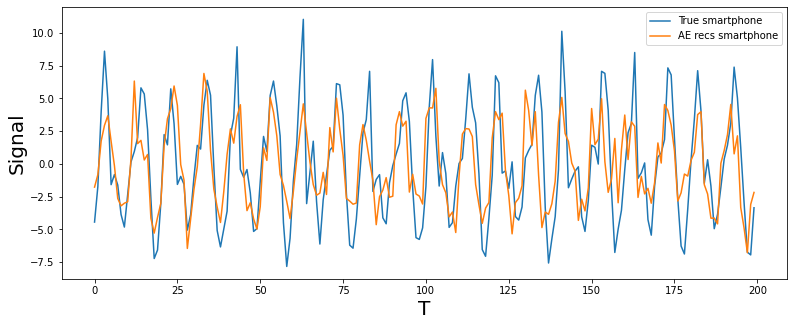

In [194]:
plt.figure(figsize=(13,5))

dataiter = iter(data_loader)
images, labels = dataiter.next()
plt.plot(images[0,:], label = 'True smartphone')
plt.xlabel("T", fontsize = 20)
plt.ylabel("Signal", fontsize = 20)
plt.plot(model(images.cuda()).cpu().detach().numpy()[0,:], label = 'AE recs smartphone')
plt.legend()
plt.show()


In [169]:

model_watch = Autoencoder_Linear_watch().cuda()

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_watch.parameters(),
                             lr=5e-3)

# Point to training loop video
num_epochs = 100
outputs = []
for epoch in range(num_epochs):
    for (img, _) in data_loader_watch:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        img = img.cuda()
        recon = model_watch(img)
        loss = criterion(recon, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, img, recon))

Epoch:1, Loss:11.6561
Epoch:2, Loss:10.6357
Epoch:3, Loss:10.0519
Epoch:4, Loss:9.8500
Epoch:5, Loss:9.8246
Epoch:6, Loss:9.7511
Epoch:7, Loss:9.6515
Epoch:8, Loss:9.5341
Epoch:9, Loss:9.4542
Epoch:10, Loss:9.3115
Epoch:11, Loss:9.2252
Epoch:12, Loss:9.1042
Epoch:13, Loss:8.9821
Epoch:14, Loss:8.8900
Epoch:15, Loss:8.8203
Epoch:16, Loss:8.6085
Epoch:17, Loss:8.5399
Epoch:18, Loss:8.5557
Epoch:19, Loss:8.3566
Epoch:20, Loss:8.2471
Epoch:21, Loss:8.0171
Epoch:22, Loss:7.9412
Epoch:23, Loss:7.8437
Epoch:24, Loss:7.7085
Epoch:25, Loss:7.5714
Epoch:26, Loss:7.4474
Epoch:27, Loss:7.3679
Epoch:28, Loss:7.2299
Epoch:29, Loss:7.0896
Epoch:30, Loss:7.0497
Epoch:31, Loss:6.8741
Epoch:32, Loss:6.7529
Epoch:33, Loss:6.5852
Epoch:34, Loss:6.5135
Epoch:35, Loss:6.2979
Epoch:36, Loss:6.3206
Epoch:37, Loss:6.1128
Epoch:38, Loss:6.1533
Epoch:39, Loss:6.1023
Epoch:40, Loss:5.8266
Epoch:41, Loss:5.8554
Epoch:42, Loss:5.7460
Epoch:43, Loss:5.5595
Epoch:44, Loss:5.5167
Epoch:45, Loss:5.3744
Epoch:46, Loss:5

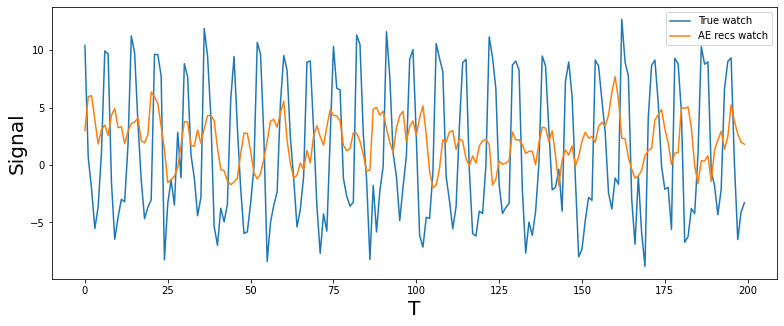

In [206]:
plt.figure(figsize=(13,5))

dataiter = iter(data_loader_watch)
images, labels = dataiter.next()
plt.plot(images[1,:], label = 'True watch')
plt.xlabel("T", fontsize = 20)
plt.ylabel("Signal", fontsize = 20)
plt.plot(model_watch(images.cuda()).cpu().detach().numpy()[0,:],  label = 'AE recs watch')
plt.legend()
plt.show()


## Approximation

In [171]:

encoded_from_phone = []
for (img, _) in data_loader:
        encoded_from_phone.append(model.encoder(images.cuda()).cpu().detach().numpy())

encoded_from_watch = []
for (img, _) in data_loader_watch:
        
        encoded_from_watch.append(model_watch.encoder(images.cuda()).cpu().detach().numpy())


In [172]:
encoded_from_phone = np.squeeze(np.array(encoded_from_phone)).reshape(1024,16)
encoded_from_watch = np.squeeze(np.array(encoded_from_watch)).reshape(1024,16)

In [173]:
X_train = encoded_from_phone
y_train = encoded_from_watch

### PLS as multimodel

In [202]:
pls = PLSRegression(n_components=20).fit(X_train, y_train)
y_pred = pls.predict(X_train)

C:\Users\safiu\anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:185: FutureWarning: As of version 0.24, n_components(20) should be in [1, n_features].n_components=16 will be used instead. In version 1.1 (renaming of 0.26), an error will be raised.
  warnings.warn(


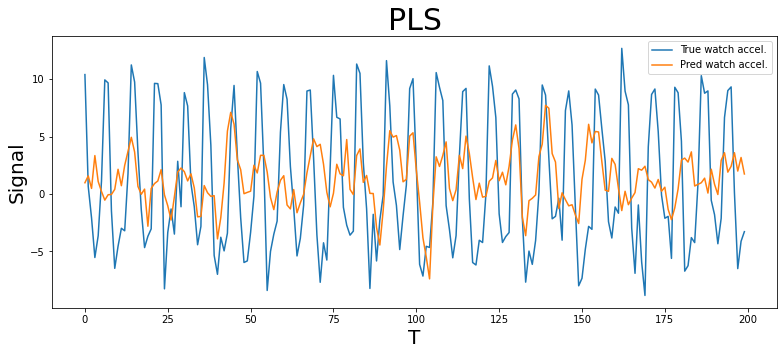

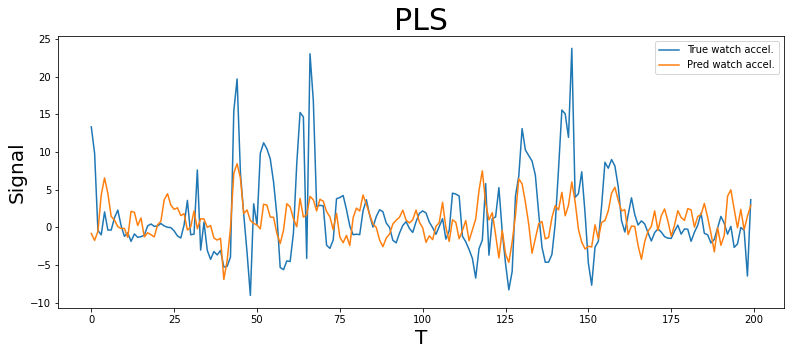

In [205]:
plt.figure(figsize=(13,5))

plt.plot(dataset_watch[1][0].detach().numpy(), label = 'True watch accel.')
plt.plot(model_watch.decoder(torch.tensor(y_pred.astype(np.float32)).cuda()).cpu().detach().numpy()[1,:], label = 'Pred watch accel.')
plt.title('PLS', fontsize = 30)
plt.xlabel("T", fontsize = 20)
plt.ylabel("Signal", fontsize = 20)
plt.legend()
# plt.savefig('PLS.png')
plt.show()
plt.figure(figsize=(13,5))

plt.plot(dataset_watch[13][0].detach().numpy(), label = 'True watch accel.')
plt.plot(model_watch.decoder(torch.tensor(y_pred.astype(np.float32)).cuda()).cpu().detach().numpy()[13,:], label = 'Pred watch accel.')
plt.title('PLS', fontsize = 30)
plt.xlabel("T", fontsize = 20)
plt.ylabel("Signal", fontsize = 20)
plt.legend()
plt.savefig('PLS.png')

## NN for hidden $\rightarrow$ hidden

In [176]:
class model_multi(nn.Module):
    def __init__(self):
        super(model_multi, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
#             nn.Linear(64, 32),
#             nn.ReLU(),
            nn.Linear(64, 16),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    

net = model_multi().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(),
                             lr=5e-4)


In [177]:
x = X_train
y = y_train
inputs = Variable(torch.Tensor(x)).cuda()
outputs = Variable(torch.Tensor(y)).cuda()
for i in range(1000):
       prediction = net(inputs)
       loss = criterion(prediction, outputs) 
       optimizer.zero_grad()
       loss.backward()        
       optimizer.step()       



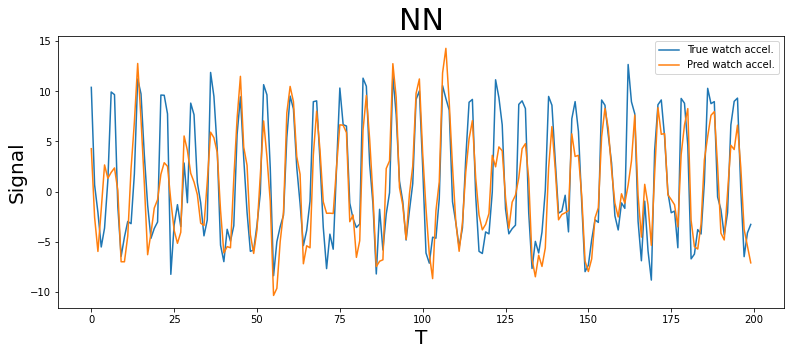

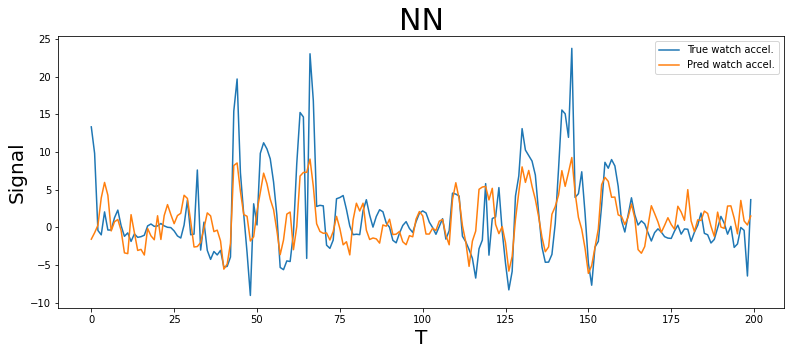

In [200]:
y_pred = net.forward(torch.tensor(X_train).cuda())

plt.figure(figsize=(13,5))
plt.plot(dataset_watch[1][0].detach().numpy(), label = 'True watch accel.')
plt.plot(model_watch.decoder((y_pred).cuda()).cpu().detach().numpy()[1,:], label = 'Pred watch accel.')
plt.title('NN', fontsize = 30)
plt.xlabel("T", fontsize = 20)
plt.ylabel("Signal", fontsize = 20)
plt.legend()
plt.savefig('NNpred.png')



plt.figure(figsize=(13,5))
plt.plot(dataset_watch[13][0].detach().numpy(), label = 'True watch accel.')
plt.plot(model_watch.decoder((y_pred).cuda()).cpu().detach().numpy()[13,:], label = 'Pred watch accel.')
plt.title('NN', fontsize = 30)
plt.xlabel("T", fontsize = 20)
plt.ylabel("Signal", fontsize = 20)
plt.legend()
plt.savefig('NNpred.png')